In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from typing import List, Union

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from omegaconf import OmegaConf
from torch.cuda.amp import autocast
from torch.nn import CTCLoss

import os
import os.path as osp
from glob import glob
from tqdm.auto import tqdm
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

import sys
sys.path.append('/root/mediazen/speech2blendshape/')

from src.dataset import FaceDataset
from src.model import S2BModel
from src.models.full_deepspeech import DeepSpeech
from src.utils import plot_spectrogram, plot_result

/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [3]:
# dataset

data_dir = '/root/mediazen/speech2anim/essentials_1443'
essentials_dir = [d.path for d in os.scandir(data_dir)]
audio_path, shape_path = essentials_dir
audio_path, shape_path

audio_pt = torch.load(audio_path)
shape_pt = torch.load(shape_path)

ds = FaceDataset(audio_pt[2], audio_pt[3], shape_pt[3], shape_pt[4], (audio_pt[1], shape_pt[0]))

In [25]:
device = 'cuda'
dl = torch.utils.data.DataLoader(ds[1288:1291], batch_size=3, num_workers=64, pin_memory=False)
for batch in dl:
    spec, spec_len, blendshape, blendshape_len, idx, timecode = batch
spec = spec.to(device)
spec_len = spec_len.to(device)
blendshape = blendshape.to(device)
blendshape_len = blendshape_len.to(device)
spec.shape, spec_len, blendshape.shape, blendshape_len

(torch.Size([3, 11682, 161]),
 tensor([4914, 4140, 5754], device='cuda:0', dtype=torch.int32),
 torch.Size([3, 7012, 16]),
 tensor([2952, 2489, 3457], device='cuda:0', dtype=torch.int32))

In [5]:
encoder = DeepSpeech.load_model('/root/mediazen/speech2blendshape/pretrained/librispeech_pretrained_v2.pth')
encoder.to(device)
None

In [6]:
enc_out, enc_len = encoder(spec, spec_len)
enc_out = enc_out.permute(1, 2, 0).contiguous()

In [7]:
enc_out.shape

torch.Size([3, 29, 2877])

In [8]:
model = S2BModel(0.0001, 1024, 1024, 16)
model = model.to(device)

In [9]:
speech_features = model.interpolate_features(enc_out, enc_len, blendshape_len)
# speech_features = speech_features.permute(0, 2, 1)

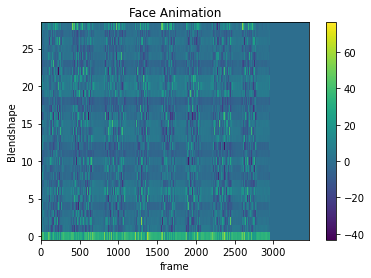

In [10]:
plot_result(speech_features[0].cpu().detach())

In [11]:
speech_features.shape

torch.Size([3, 29, 3457])

In [12]:
B, C, T = speech_features.shape
W = 16

In [13]:
import torch.nn.functional as F

out = F.pad(speech_features, (W//2-1, W//2))
out.shape

torch.Size([3, 29, 3472])

In [14]:
out[:,:,:16].unsqueeze(1).shape

torch.Size([3, 1, 29, 16])

In [15]:
padded_features = F.pad(speech_features, (W//2-1, W//2))
output_features = torch.zeros((B, T, C, W)).to(device)

for seq in range(T):
    windowed_features = padded_features[:,:,seq:seq+W].unsqueeze(1)
    output_features[:,seq:seq+1,:,:] = windowed_features


In [16]:
output_features.shape

torch.Size([3, 3457, 29, 16])

In [17]:
B, T, C, W = output_features.shape
output_features = output_features.view(B*T, C, W, 1)
output_features.shape

torch.Size([10371, 29, 16, 1])

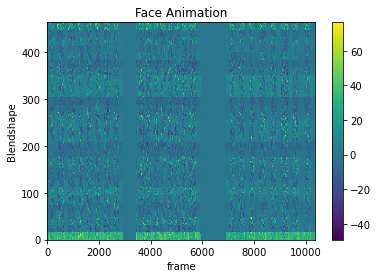

In [18]:
plot_result(output_features.view(10371, -1).T.squeeze().cpu().detach())

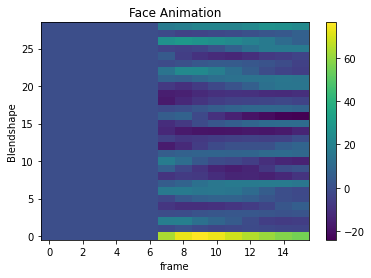

In [19]:
plot_result(output_features[0].squeeze().cpu().detach())

In [26]:
convNet = nn.Sequential(
    nn.Conv2d(29, 32, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), #  29 x 16 x 1 => 32 x 8 x 1
    nn.LeakyReLU(0.02, True),
    nn.Conv2d(32, 32, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), # 32 x 8 x 1 => 32 x 4 x 1
    nn.LeakyReLU(0.02, True),
    nn.Conv2d(32, 64, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), # 32 x 4 x 1 => 64 x 2 x 1
    nn.LeakyReLU(0.2, True),
    nn.Conv2d(64, 64, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), # 64 x 2 x 1 => 64 x 1 x 1
    nn.LeakyReLU(0.2, True),
)
convNet = convNet.to(device)

In [27]:
convout = convNet(output_features)
convout = convout.view(B, T, -1)
convout.shape

torch.Size([3, 3457, 64])

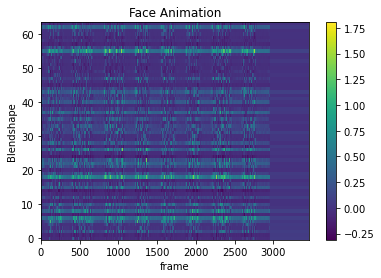

In [28]:
plot_result(convout[0].T.cpu().detach())

In [29]:
blendshape_len

tensor([2952, 2489, 3457], device='cuda:0', dtype=torch.int32)

In [30]:
fullNet = nn.Sequential(
    nn.Linear(in_features=64, out_features=128, bias=True),
    nn.LeakyReLU(0.02),

    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.LeakyReLU(0.02),            

    nn.Linear(in_features=64, out_features=32, bias=True),          
    nn.Tanh()
    )
fullNet = fullNet.to(device)

In [31]:
fcout = fullNet(convout)
fcout.shape

torch.Size([3, 3457, 32])

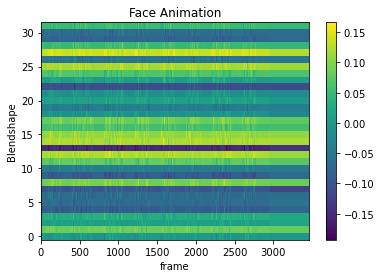

In [32]:
plot_result(fcout[0].T.cpu().detach())

In [34]:
B, T, C = fcout.shape
W = 8
fcout = fcout.permute(0, 2, 1)
padded_features = F.pad(fcout, (W//2-1, W//2))
padded_features.permute(0, 2, 1)
output_features = torch.zeros((B, T, C, W)).to(device)

for seq in range(T):
    windowed_features = padded_features[:,:,seq:seq+W].unsqueeze(1)
    output_features[:,seq:seq+1,:,:] = windowed_features

output_features.shape


torch.Size([3, 3457, 32, 8])

In [37]:
output_features = output_features.view(B*T, C, W)
output_features.shape

torch.Size([10371, 32, 8])

In [39]:
# attention
attentionConvNet = nn.Sequential( # b x subspace_dim x seq_len
    nn.Conv1d(32, 16, kernel_size=3, stride=1, padding=1, bias=True),
    nn.LeakyReLU(0.02, True),
    nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1, bias=True),
    nn.LeakyReLU(0.02, True),
    nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1, bias=True),
    nn.LeakyReLU(0.02, True),
    nn.Conv1d(4, 2, kernel_size=3, stride=1, padding=1, bias=True),
    nn.LeakyReLU(0.02, True),
    nn.Conv1d(2, 1, kernel_size=3, stride=1, padding=1, bias=True),
    nn.LeakyReLU(0.02, True)
)
attentionNet = nn.Sequential(
    nn.Linear(in_features=W, out_features=W, bias=True),   
    nn.Softmax(dim=1)
    )

attentionConvNet.to(device)
attentionNet.to(device)

Sequential(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): Softmax(dim=1)
)

In [66]:
att_conv_out.shape

torch.Size([10371, 1, 8])

In [42]:
att_conv_out = attentionConvNet(output_features)
att_out = attentionNet(att_conv_out)
att_out = att_out.permute(0, 2, 1)
att_out.shape

torch.Size([10371, 8, 1])

In [65]:
final_features = torch.bmm(output_features, att_out)
final_features.shape

torch.Size([10371, 32, 1])

In [44]:
final_features = torch.bmm(output_features, att_out)
final_features = final_features.view(B, T, C)
final_features.shape

torch.Size([3, 3457, 32])

In [56]:
class ClipModule(nn.Module):
    def __init__(self, min_threshold, max_threshold):
        super(ClipModule, self).__init__()
        self.min_threshold = min_threshold
        self.max_threshold = max_threshold

    
    def forward(self, x):
        return torch.clamp(x, min=self.min_threshold, max=self.max_threshold)

fully_connected = nn.Sequential(
    nn.Linear(32, 16, bias=False),
    ClipModule(0, 1)
)
fully_connected.to(device)

Sequential(
  (0): Linear(in_features=32, out_features=16, bias=False)
  (1): ClipModule()
)

In [57]:
preds = fully_connected(final_features)
preds.shape

torch.Size([3, 3457, 16])

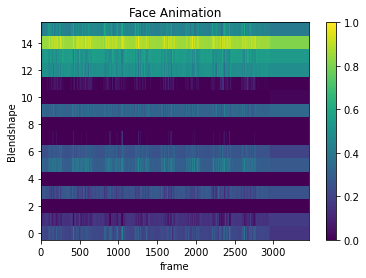

In [58]:
plot_result(preds[0].T.cpu().detach())

In [67]:
speech_features.shape

torch.Size([3, 29, 3457])

In [68]:
fc = nn.Linear(29, 16)
fc.to(device)

speech_features = speech_features.permute(0, 2, 1)
sf = fc(speech_features)
sf.shape

torch.Size([3, 3457, 16])